# Wind Turbine Benchmark Analysis with Annual Energy Productions and Capacity Factors

### Cihan Erturk  (Lead R&D Engineer / Data Scientist) 


## SUMMARY

&emsp;&emsp;This project aims to evaluate how leading Wind Turbine companies bid against each other from a technical perspective. I wanted to answer the questions below with this study;
- Which companies present most versatile solutions?
- Which companies produce the turbines with highest energy yields?
- Which companies produce the most efficient wind turbines? 

&emsp;&emsp;The dataset is provided by Open Energy Platform.[[1]](#References) It is a collection of the available information on the specification sheets provided by the manufacturers until **2019**. I explored the data and built three different wind distribution profiles to compare annual energy productions and capacity factors.

##### TLDR

- **Vestas** is the **most versatile company** with the most wind turbines in the dataset. The company provides several different configurations for each power category. **Enercon** and **Siemens** also stand out with their wide power range of solutions.

- **Enercon** wind turbines reveal significantly better performance on overall **turbine blade efficiency**. **Siemens**, **Adwen/Areva** and **Eno** are marginally better than other companies on this parameter.

- **Vestas V164/8MW** configuration is the **highest annual energy yielding** turbine. **Senvion**, **Enercon** , **Nordex** and **Siemens** also have highest yielding wind turbines on lower power categories.

- **Siemens** wind turbines achieve better overall average **capacity factors**. **GE Wind** and **Nordex** have some small lead on overall average capacity. **Vestas** and **Enercon** have also wind turbines with leading capacity factors on some power categories.

###### DISCLAIMER: The information in this study is intended solely for the personal non-commercial use of the user who accepts full responsibility for its use. The information contained in this project is provided on an "as is" basis with no guarantees of completeness, accuracy, usefulness or timeliness.
###### DISCLAIMER 2: This project was accomplished by Cihan Erturk in his personal capacity.The opinions expressed in this article are the author's own and do not reflect the view of any corporate entity.

### Contents
   - [SUMMARY](#SUMMARY)
   - [References](#References)
   - [I. Data Insights](#I.-Data-Insights)
   - [II. General Overview of Turbine Rotor Efficiency](#II.-General-Overview-of-Turbine-Rotor-Efficiency)
   - [III. Generation of Reference Wind Speed Distributions ](#III.-Generation-of-Reference-Wind-Speed-Distributions)
   - [IV. Turbine Power Curve Regression Models](#IV.-Turbine-Power-Curve-Regression-Models)
   - [V. Annual Energy Production Estimations](#V.-Annual-Energy-Production-Estimations)
   - [VI. Capacity Factor Estimations](#VI.-Capacity-Factor-Estimations)
   - [Conclusions](#Conclusions)
   - [Limitations](#Limitations)

### References

 1. Open Energy Platform Wind Turbine Library, **https://openenergy-platform.org/dataedit/view/supply/wind_turbine_library**
 2. 'Estimation of Weibull parameters for wind energy analysis across the UK' , Z. R. Shu / Mike Jesson, 27.01.2021, **https://aip.scitation.org/doi/10.1063/5.0038001**

In [21]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import weibull_min
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures

#read_wind_turbine_data
Wt = pd.read_csv('C:/Users/ghane/Projects/WindTurbineProject/supply__wind_turbine_library.csv')
pd.set_option('display.max_columns', 50)
#display(Wt.head())
#display(Wt.info())
#display(Wt.describe(include='all'))

## I. Data Insights

- **141** wind turbines are included in the project from 9 main manufacturers. **Vestas** is the manufacturer with the **most** wind turbines in the dataset with **28** different turbines. **Siemens** and **Nordex** follow closely.

- **Most common power** options for wind turbines are **3MW**, **2.5MW** and **3.6MW** respectively. 

- **Vestas** manufactures the wind turbines with the highest power output of **9.5MW** and **8MW**. **Adwen/Areva** and **Enercon** follows with **8MW** and **7.6MW** turbines.

- **Vestas** provides the largest range of wind turbine solutions from **1.8MW** to **9.5MW**. **Enercon** and **Siemens** also present a wide power range of **0.8MW - 7.6MW** and **1.3MW - 7MW**, respectively.

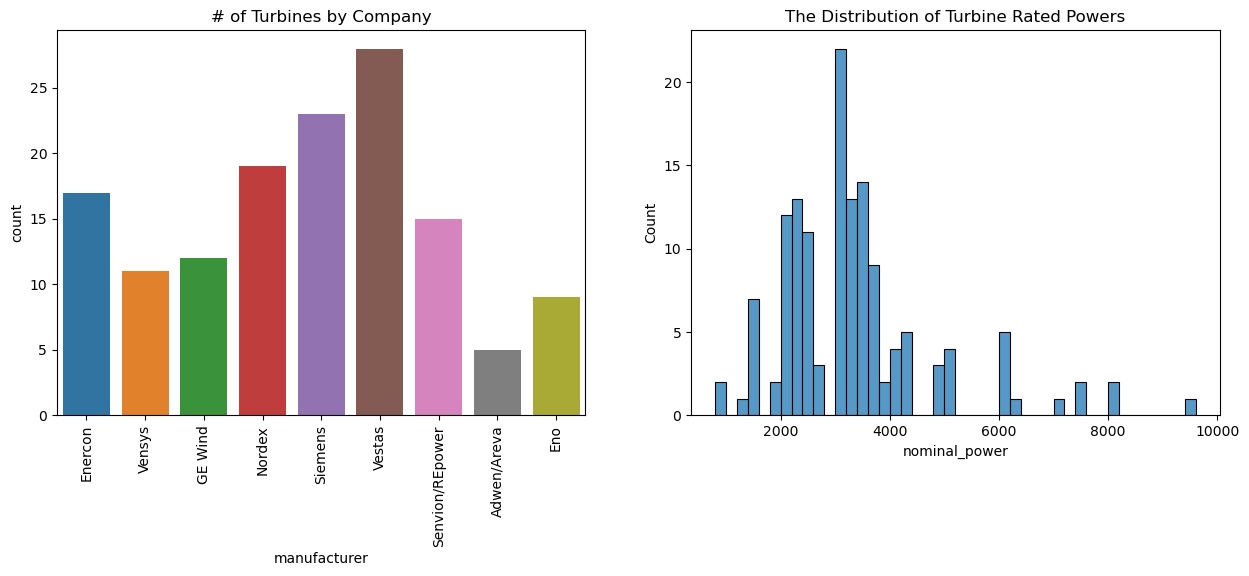

In [22]:
#Drop manufacturers with the insufficient data
Wt= Wt[~Wt['manufacturer'].isin(['aerodyn', 'IEA'])]

fig, ax = plt.subplots(1,2,figsize=(15,5))
#Dataset Company Category Counts
sns.countplot(data=Wt, x='manufacturer', ax=ax[0])\
            .set(title='# of Turbines by Company')
#Turbine Power Distribution Graph
ax[0].tick_params(axis='x', rotation=90)
sns.histplot(data=Wt, x='nominal_power', binwidth=200, ax=ax[1])\
            .set(title='The Distribution of Turbine Rated Powers')
plt.show()

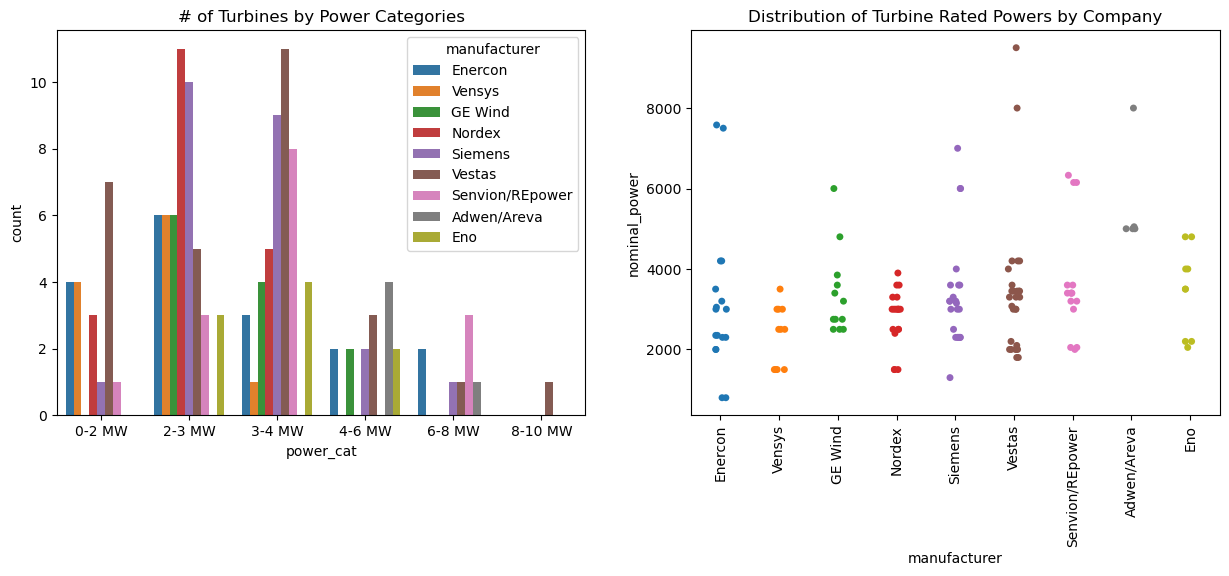

In [23]:
#Generating power categories for the dataset
group_names =['0-2 MW', '2-3 MW', '3-4 MW', '4-6 MW','6-8 MW', '8-10 MW']
ranges = [0,2000,3000,4000,6000,8000,np.inf]
Wt['power_cat'] = pd.cut(Wt['nominal_power'], bins=ranges, labels=group_names)


fig, ax = plt.subplots(1,2,figsize=(15,5))
#Power Category Distribution Plot
sns.countplot(data=Wt, x= 'power_cat', hue='manufacturer', ax=ax[0])\
            .set(title='# of Turbines by Power Categories')
sns.move_legend(ax[0], "upper right")
# Turbine Power by Company Distribution Plot
sns.stripplot(data=Wt, x='manufacturer', y='nominal_power', ax=ax[1])\
            .set(title='Distribution of Turbine Rated Powers by Company')
ax[1].tick_params(axis='x', rotation=90)

plt.show()

## II. General Overview of Turbine Rotor Efficiency

&emsp;&emsp;A rudimentary calculation is done to compare the turbine blade efficiency of the wind turbines. An **blade efficiency coefficient** is calculated by dividing the **Nominal Power** to **Rotor Area**. However, I need to warn you that this parameter **can be misleading** since curtailment rate for different companies and different wind turbines may vary a lot. We have **no data for curtailment rate.**

- There is a weak correlation between blade efficiency and power.

- **Enercon** has significantly better performance on overall turbine blade efficiency. **Siemens**, **Adwen/Areva** and **Eno** are marginally better than other companies. 

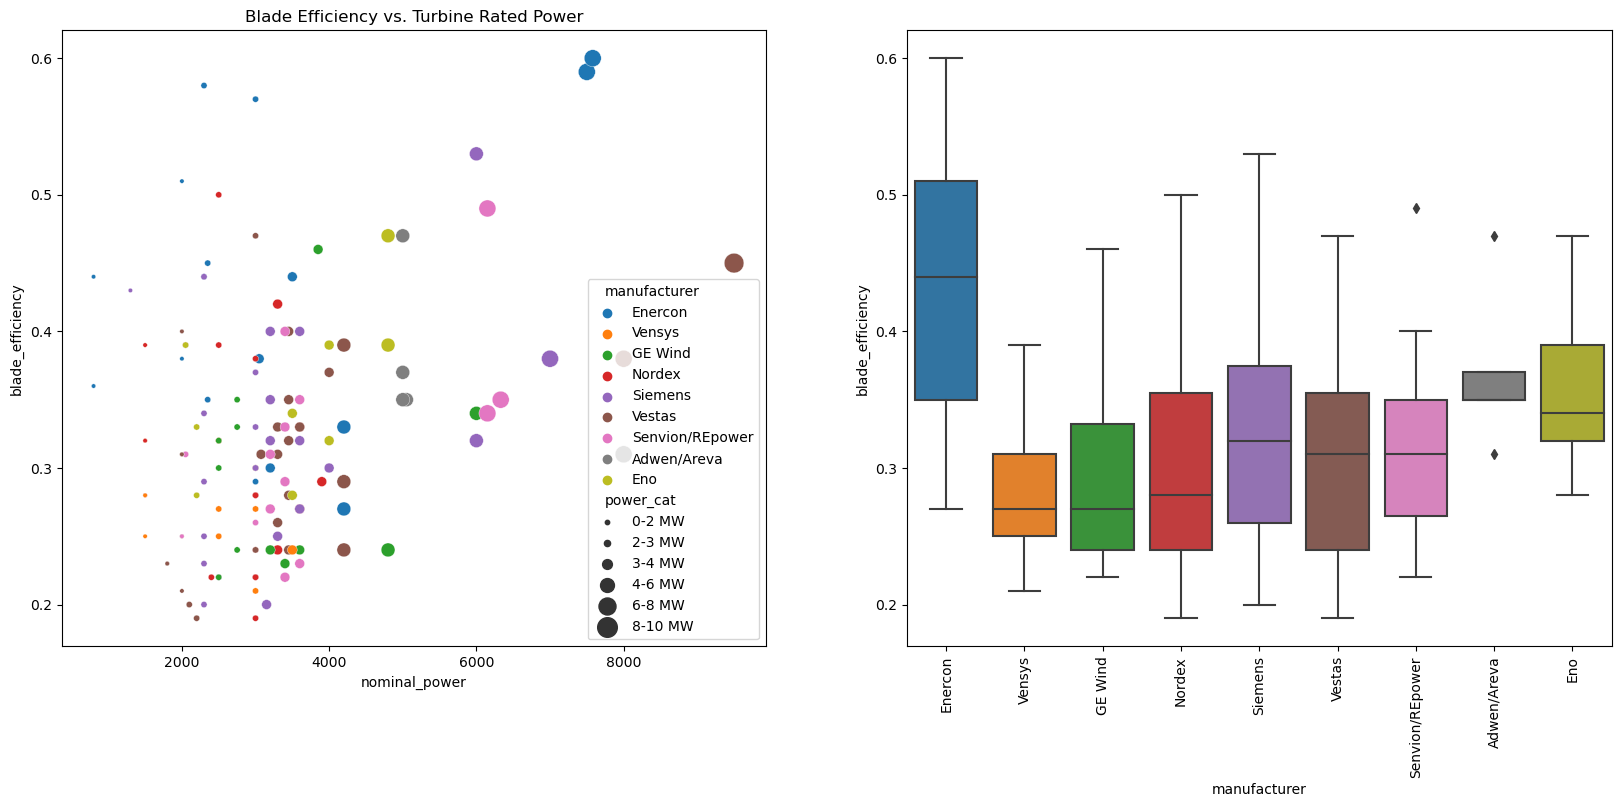

In [24]:
#Blade Efficiency Parameter Calc.
Wt['blade_efficiency'] = round(Wt['nominal_power'] / Wt['rotor_area'], 2)

fig,ax = plt.subplots(1,2,figsize=(20,8))

#Blade Efficiency vs Nominal Power Scatterplot
sns.scatterplot(data=Wt, x='nominal_power', y='blade_efficiency', 
                hue='manufacturer',size='power_cat',
                sizes={'0-2 MW':10, '2-3 MW':20, '3-4 MW':50, '4-6 MW':100,'6-8 MW':150, '8-10 MW':200}, ax=ax[0])\
                .set(title='Blade Efficiency vs. Turbine Rated Power')

#Blade Efficiency by Manufacturers Boxplots
sns.boxplot(data=Wt, x='manufacturer', y='blade_efficiency', ax=ax[1])
ax[1].tick_params(axis='x', rotation=90)

plt.show()

## III. Generation of Reference Wind Speed Distributions 

&emsp;&emsp;The wind speed distribution during the year should be known to calculate the annual energy production of wind turbines. Three different wind speed profiles are generated for the project. The Weibull distribution is often a good approximation for the wind speed distribution. Reference samples are constructed by studying the weibull parameters across UK.[[2]](#References)

<center><img src="./UK_weibull_c_k.png" width="800" height="800" /></center>

<b><center>Distribution of Weibull scale(c) and shape(k) parameters across UK.</center></b>

&emsp;&emsp;Three hypothetical wind speed probability density curves are defined with the parameters below:
    
    - W1(c=2.2, k=11.0, mean speed=9.7 m/s, stdev=10.9 m/s)
    - W2(c=2.5, k=8.0, mean speed=7.1 m/s, stdev=4.6 m/s) 
    - W3(c=2.8, k=5.0, mean speed=4.5 m/s, stdev=1.5 m/s)
    
&emsp;&emsp;Annual random wind speed samples are generated with hourly spans for each curve. Generated sample arrays will be used with the wind turbine power curves to calculate annual energy productions and capacity factors.

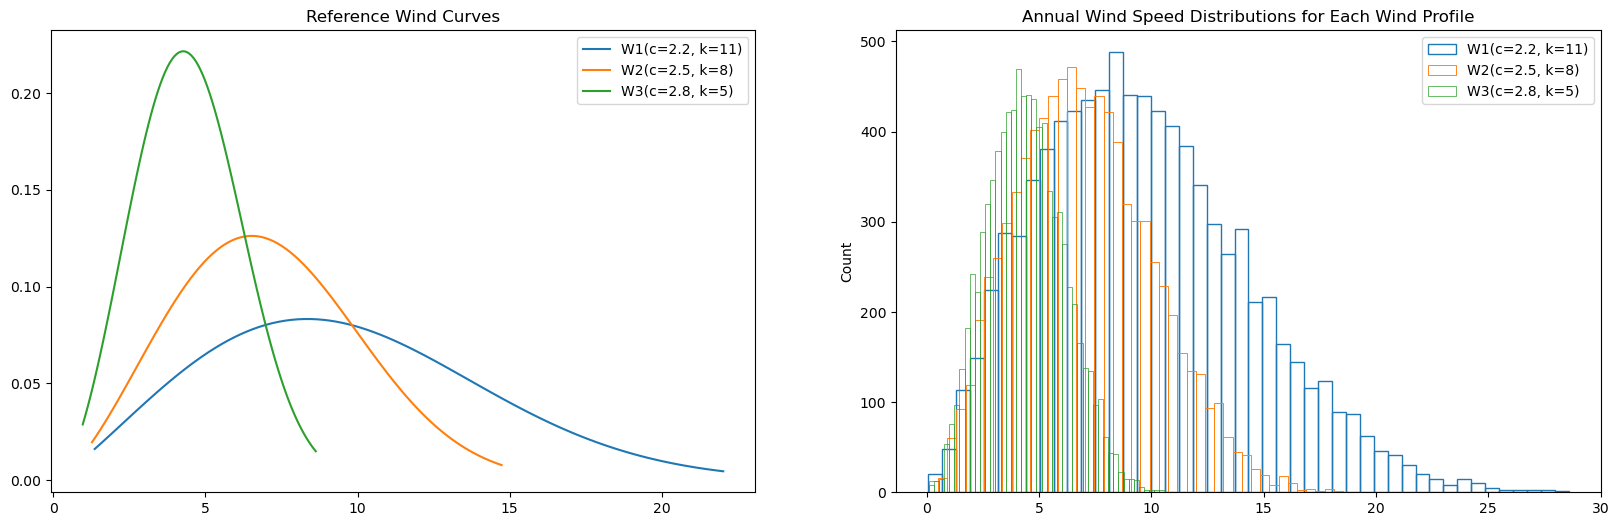

In [25]:
#mean5, var5, skew5, kurt5 = weibull_min.stats(2.8,scale=5.0, moments='mvsk')
#mean8, var8, skew8, kurt8 = weibull_min.stats(2.5,scale=8.0, moments='mvsk')
#mean11, var11, skew11, kurt11 = weibull_min.stats(2.2,scale=11.0, moments='mvsk')



fig,ax = plt.subplots(1,2,figsize=(20,6))

#Generating wind profiles
w11_x = np.linspace(weibull_min.ppf(0.01, 2.2, scale=11.0),
                weibull_min.ppf(0.99, 2.2, scale=11.0), 100)

w8_x = np.linspace(weibull_min.ppf(0.01,2.5 , scale=8.0),
                weibull_min.ppf(0.99, 2.5, scale=8.0), 100)

w5_x = np.linspace(weibull_min.ppf(0.01, 2.8, scale=5.0),
                weibull_min.ppf(0.99, 2.8, scale=5.0), 100)

#Generating Annual Wind Speed Samples Array
W1 = weibull_min.rvs(2.2, scale=11.0, size=8760, random_state=42)
W2 = weibull_min.rvs(2.5, scale=8.0, size=8760, random_state=42)
W3 = weibull_min.rvs(2.8, scale=5.0, size=8760, random_state=42)

#Lineplots of Reference Wind Profiles
sns.lineplot(x=w11_x, y=weibull_min.pdf(w11_x, 2.2,scale=11.0), ax=ax[0])
sns.lineplot(x=w8_x, y=weibull_min.pdf(w8_x, 2.5,scale=8.0), ax=ax[0])
sns.lineplot(x=w5_x, y=weibull_min.pdf(w5_x, 2.8,scale=5.0), ax=ax[0]).set(title='Reference Wind Curves')

ax[0].legend(loc='upper right', labels=['W1(c=2.2, k=11)', 'W2(c=2.5, k=8)', 'W3(c=2.8, k=5)'])


# Histograms of Annual Wind Speed Distributions for Each Wind Profile
sns.histplot(x=W1, fill=False, ax=ax[1])
sns.histplot(x=W2, fill=False, ax=ax[1])
sns.histplot(x=W3, fill=False, ax=ax[1]).set(title='Annual Wind Speed Distributions for Each Wind Profile')
ax[1].legend(loc='upper right', labels=['W1(c=2.2, k=11)', 'W2(c=2.5, k=8)', 'W3(c=2.8, k=5)'])

plt.show()

## IV. Turbine Power Curve Regression Models

&emsp;&emsp;**66** wind turbines have 'wind vs. power' data available in the dataset. **Decision Tree Regression models** will be used to fit power functions and predict hourly power generations. An example model curve with real set data points are plotted below.

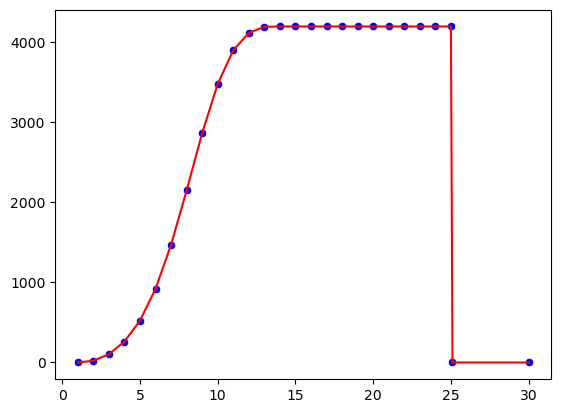

In [26]:
curve_wind_speed = Wt[Wt['has_power_curve'] == True]['power_curve_wind_speeds'].str.strip('[]')
curve_wind_speed = curve_wind_speed.str.replace(' ', '')
curve_wind_speed = curve_wind_speed.str.split(',')
ws_arr = [[float(i) for i in val] for val in curve_wind_speed]

curve_power = Wt[Wt['has_power_curve'] == True]['power_curve_values'].str.strip('[]')
curve_power = curve_power.str.replace(' ', '')
curve_power = curve_power.str.split(',')
pwr_arr = [[float(i) for i in val] for val in curve_power]

X = ws_arr[0] + [ws_arr[0][-1]+0.1] + [ws_arr[0][-1]+5]
y = pwr_arr[0] + [0] + [0]
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(np.array(X).reshape(-1,1))
reg_model = DecisionTreeRegressor()
reg_model.fit(poly_features, y)
preds= reg_model.predict(poly_features)
sns.lineplot(x=X, y=preds, color='red')
sns.scatterplot(x=X, y=y, color='blue')
plt.show()

## V. Annual Energy Production Estimations

&emsp;&emsp; Power curve regression models and reference wind arrays are used to estimate hourly power outputs. Hourly power outputs are summed to calculate the **total energy production**. Total energy production is factored with **%95 production-based availability rate** to estimate **Annual Energy Productions(AEP)**. 


In [27]:
#Annual Energy Production Calculation Function
def AEP_calc(arr_w, arr_p, ref_w):
    """Receives:power curve speed(list), 
                power curve power output(list)
                reference annual wind distribution with hourly spans(list) 
        Result: Annual Energy production with %95 production availability rate(int)"""
    X = arr_w + [arr_w[-1]+0.1] + [arr_w[-1]+5]
    y = arr_p + [0] + [0]
    poly = PolynomialFeatures(degree=3, include_bias=False)
    poly_features = poly.fit_transform(np.array(X).reshape(-1,1))
    reg_model = DecisionTreeRegressor()
    reg_model.fit(poly_features, y)
    X_pred = poly.fit_transform(np.array(ref_w).reshape(-1,1))
    preds= reg_model.predict(X_pred)
    AEP = np.sum(preds)*0.95
    return int(AEP/1000)

#Initialize Empty Lists for AEP results
W1_aep = []
W2_aep = []
W3_aep = []

#Calculate AEP for the turbines with each wind distributions
for wind, power in zip(ws_arr, pwr_arr):
    res_w1 = AEP_calc(wind, power, W1)
    W1_aep.append(res_w1)
    res_w2 = AEP_calc(wind, power, W2)
    W2_aep.append(res_w2)
    res_w3 = AEP_calc(wind, power, W3)
    W3_aep.append(res_w3)

#Create a new DataFrame includes only Wind Turbines with power curve data 
Wt_pwr = Wt[Wt['has_power_curve'] == True].reset_index()

#Joining AEP with the Dataframe
AEP = pd.DataFrame({'AEP1':W1_aep, 'AEP2':W2_aep, 'AEP3':W3_aep})
Wt_pwr = pd.concat([Wt_pwr, AEP], axis=1)

- **Vestas** produces the **leading V164/8MW** turbine with **max 42900 MWh AEP** and **average 27200 MWh AEP**. The turbine also has 9.5MW option with similar AEP values.

- **Senvion S152/6.3MW** is in **second** place with **max 33600 MWh AEP** and **average 21400 MWh AEP**.

- Leading wind turbines on lower power categories are listed below:

        - 4-6MW : Enercon E141/4.2MW - max 21300 MWh / avg 13300 MVh
        - 3-4MW : Siemens SWT130/3.6MW - max 18700 MWh / avg 11600 MVh
        - 2-3MW : Nordex N131/3MW & Vestas V126/3MW - max both 16100 MWh / avg Nordex 10500 MWh / avg Vestas 10200 MWh
        - 0-2MW : Senvion MM100/2MW - max 10500 MWh / avg 6600 MWh

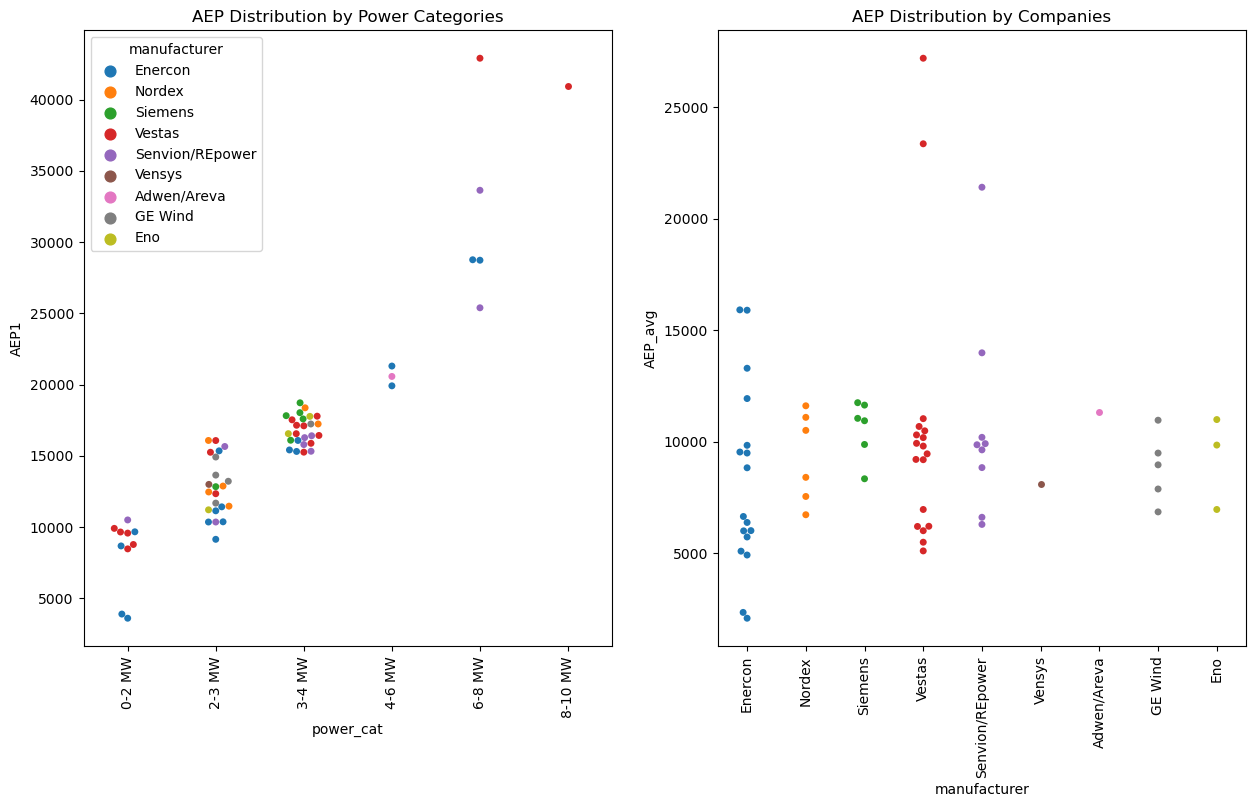

In [28]:
#Calculate average AEP(Annual Energy )
Wt_pwr['AEP_avg'] = (Wt_pwr['AEP1'] + Wt_pwr['AEP2'] + Wt_pwr['AEP3'])/3

fig,ax = plt.subplots(1,2,figsize=(15,8))

#AEP Distribution by Power Categories
sns.swarmplot(data=Wt_pwr, y='AEP1',x='power_cat',hue='manufacturer', ax=ax[0])\
            .set(title='AEP Distribution by Power Categories')
ax[0].tick_params(axis='x', rotation=90)

#AEP Distribution by Companies
sns.swarmplot(data=Wt_pwr, y='AEP_avg',x='manufacturer', ax=ax[1])\
            .set(title='AEP Distribution by Companies')
ax[1].tick_params(axis='x', rotation=90)
plt.show()

## VI. Capacity Factor Estimations

&emsp;&emsp; The expected capacity factors are calculated by dividing Annual Energy Production with ( 365 days * 24 hours * nominal_power_rate). Overall average capacity factor and seperate factors for each wind profile are calculated for the project.

- **Siemens** wind turbines have better overall average capacity factors. **GE Wind** and **Nordex** also have some small lead on overall average capacity.  

- Leading wind turbines on capacity factors for each power category is listed below:

        - 8-10 MW : Vestas V164/9.5MW - max 0.49 / avg 0.28 
        - 6-8 MW : Vestas V164/8MW - max 0.61 / avg  0.39
        - 4-6 MW : Enercon E141/4.2MW - max 0.58 / avg  0.36
        - 3-4 MW : Siemens SWT142/3.2MW - max 0.65 / avg  0.43
        - 2-3 MW : Siemens SWT113/2.3MW - max 0.64 / avg  0.41
        - 0-2 MW : Vestas V100/1.8MW - max 0.61 / avg 0.39

In [29]:
#Calculation of Capacity Factors for Different Wind Profiles
Wt_pwr['CP1'] = Wt_pwr['AEP1'] *1000 / 8760 / Wt_pwr['nominal_power']
Wt_pwr['CP2'] = Wt_pwr['AEP2'] *1000 / 8760 / Wt_pwr['nominal_power']
Wt_pwr['CP3'] = Wt_pwr['AEP3'] *1000 / 8760 / Wt_pwr['nominal_power']

#Calculation of Average Capacity Factor
Wt_pwr['CP_ave'] = (Wt_pwr['CP1'] + Wt_pwr['CP2'] + Wt_pwr['CP3']) / 3

#Average Capacity Factor Pivot Table
display(Wt_pwr.pivot_table(index='manufacturer', columns='power_cat', values=['CP_ave'], 
               aggfunc='mean', fill_value='-', margins=True))


CP_ave                                                    \
power_cat          0-2 MW    2-3 MW    3-4 MW    4-6 MW    6-8 MW   8-10 MW   
manufacturer                                                                  
Adwen/Areva             -         -         -  0.258653         -         -   
Enercon          0.308709  0.294447  0.331698  0.342697  0.240742         -   
Eno                     -  0.360679  0.339644         -         -         -   
GE Wind                 -  0.360402  0.390851         -         -         -   
Nordex                  -   0.36237   0.37571         -         -         -   
Senvion/REpower  0.376769   0.36238  0.333978         -  0.322823         -   
Siemens                 -  0.413374  0.375026         -         -         -   
Vensys                  -  0.368737         -         -         -         -   
Vestas           0.346298  0.333891  0.342788         -  0.388128  0.280706   
All               0.33431  0.342136    0.3508  0.314682  0.303051  0.280706   

                           
power_cat             All  
manufacturer               
Adwen/Areva      0.258653  
Enercon          0.303735  
Eno              0.346656  
GE Wind          0.366492  
Nordex           0.366817  
Senvion/REpower  0.342565  
Siemens          0.381418  
Vensys           0.368737  
Vestas            0.34135  
All              0.339092

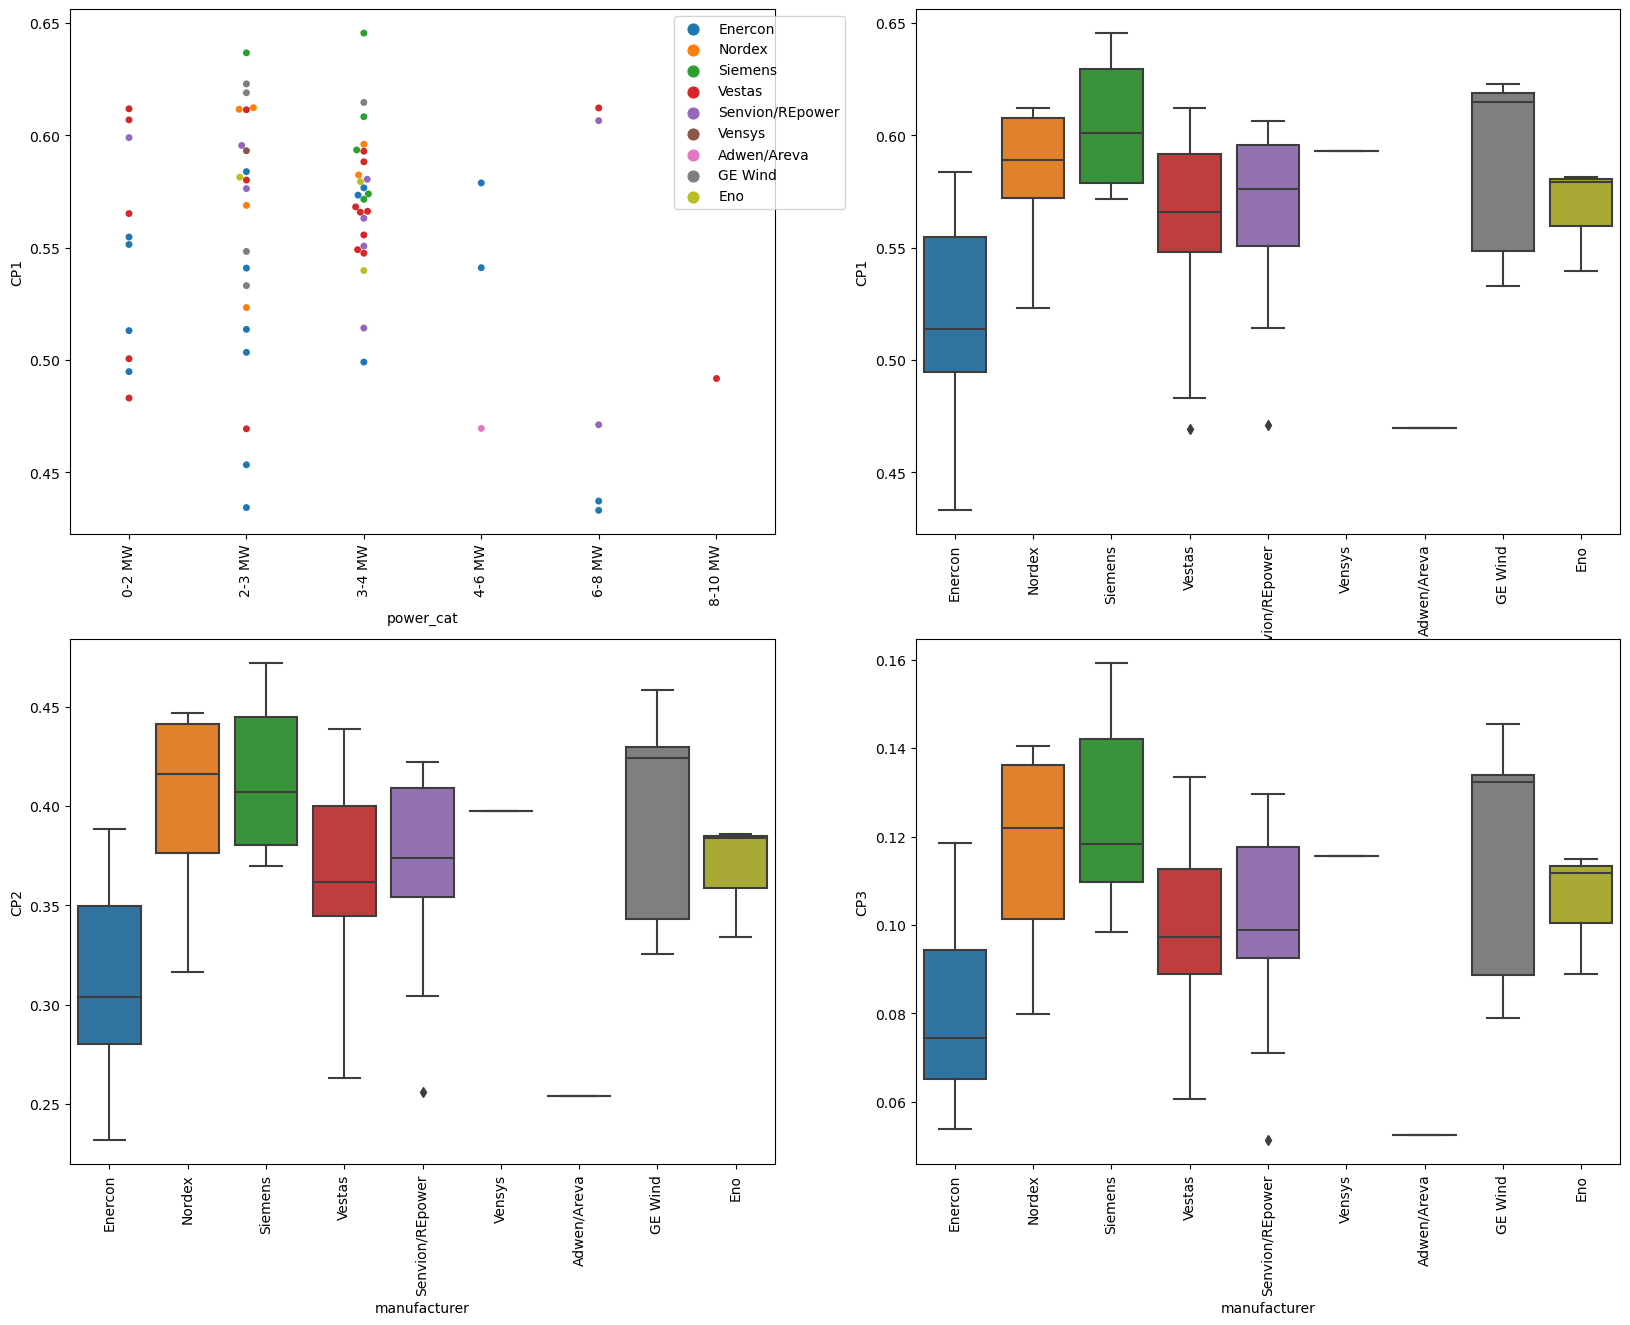

In [30]:
fig,ax = plt.subplots(2,2,figsize=(20,15))

#Capacity Factor Distribution by Companies
sns.swarmplot(data=Wt_pwr, y='CP1',x='power_cat',hue='manufacturer', ax=ax[0,0])

#Comparison of Capacity Factors on Different Wind Profiles
sns.boxplot(data=Wt_pwr, x='manufacturer', y='CP1', ax=ax[0,1])
sns.boxplot(data=Wt_pwr, x='manufacturer', y='CP2', ax=ax[1,0])
sns.boxplot(data=Wt_pwr, x='manufacturer', y='CP3', ax=ax[1,1])

ax[0,0].legend(loc='upper right', bbox_to_anchor=(1.11,1))
ax[0,0].tick_params(axis='x', rotation=90)
ax[0,1].tick_params(axis='x', rotation=90)
ax[1,0].tick_params(axis='x', rotation=90)
ax[1,1].tick_params(axis='x', rotation=90)
plt.show()

## Conclusions 

&emsp;&emsp;The wind turbine data from technical spec sheets collected from 9 companies and 141 configurations. We explored the data and used 3 different wind distribution profile to compare annual energy productions and capacity factors. Here are the results:

##### Versatileness
   - **Vestas** has the most wind turbines in the dataset. The company provides several different configurations for each power category. Besides, it was the only company that has a wind turbine solution higher than 8MW until 2019. It is concluded that **Vestas** is the company with **the most versatile solutions** in the dataset. **Enercon** and **Siemens** also stand out with their wide power range of solutions.

##### Rotor Efficiency
   - **Enercon**  wind turbines reveal significantly better performance on overall turbine blade efficiency according to some basic measurement. I want to remind that this parameter can be misleading since curtailment rate for different companies and different wind turbines may vary a lot. **Siemens**, **Adwen/Areva** and **Eno** are marginally better than other companies on this parameter.

##### Annual Energy Productions
   - **Vestas V164/8MW** configuration is the highest annual energy yielding turbine on all wind profiles with max 42900 MWh AEP and average 27200 MWh AEP. **Senvion S152/6.3MW** has also remarkable performance with max 33600 MWh AEP and average 21400 MWh AEP. **Enercon** , **Nordex** and **Siemens** also have highest yielding wind turbines on lower power categories.

##### Capacity Factors
   - **Siemens** wind turbines achieve marginally better overall average capacity factors. **Siemens SWT142/3.2MW** has a remarkable maximum capacity factor of 0.65 on the first wind profile and has an overall avg of 0.43. **GE Wind** and **Nordex**  have some small lead on overall average capacity. It is worth the mention that **Vestas** and **Enercon** have also wind turbines with leading capacity factors on some power categories. 

## Limitations

- The dataset contains wind turbine data from different commercial manufacturers until 2019. 
- There is no guarantee that the methods used to collect technical specifications are unified across all manufacturers.
- There are parameters such as air density, wake effects, wind direction etc. we didn't take into consideration. Annual energy production and capacity factors evaluated can be considered optimal values with generated wind distributions. 
- The sample size is limited to make assertive statistical measurements.